In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.utils as utils
import matplotlib.pyplot as plt
import import_ipynb
from calculate_fid import calculate_fid_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Generator(nn.Module):
    def __init__(self, text_dim, noise_dim):
        super().__init__()
        self.text_processor = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.ReLU(),
        )
        
        self.generator_network = nn.Sequential(
            nn.Linear(noise_dim + 256, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, text_input, noise):
        text_processor = self.text_processor(text_input)
        noise = noise.view(noise.size(0), -1)
        final_input = torch.cat([noise, text_processor], dim=1)
        return self.generator_network(final_input)

In [3]:
class Critic(nn.Module):
    def __init__(self, text_dim):
        super().__init__()
        self.text_encoder = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.ReLU(),
        )
        self.disc_network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        self.final_network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4 + 256, 1),
        )

    def forward(self, image_input, text_input):
        text_encoder = self.text_encoder(text_input).view(-1, 256)
        image_features = self.disc_network(image_input).view(image_input.size(0), -1)
        final_features = torch.cat([image_features, text_encoder], dim=1)
        return self.final_network(final_features)

In [4]:
def initialize_weights(model):
    if isinstance(model, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif isinstance(model, nn.BatchNorm2d):
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

gen = Generator(119, 100).to(device)
dis = Critic(119).to(device)
gen.apply(initialize_weights)
dis.apply(initialize_weights)
optim_gen = torch.optim.Adam(gen.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optim_dis = torch.optim.Adam(dis.parameters(), lr = 0.0002, betas=(0.5, 0.999))

if torch.cuda.device_count() > 1:
    gen = nn.DataParallel(gen)
    dis = nn.DataParallel(dis)

optim_gen = torch.optim.Adam(gen.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optim_dis = torch.optim.Adam(dis.parameters(), lr = 0.0002, betas=(0.5, 0.999))

def find_gradient_penalty(critic, r_samples, f_samples, input):
    alpha = torch.rand(r_samples.size(0), 1, 1, 1, device=device)
    estimates = (alpha * r_samples + (1 - alpha) * f_samples).requires_grad_(True)
    d_estimate = critic(estimates, input)
    f = torch.ones(d_estimate.shape, device=device, requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=d_estimate, inputs=estimates, grad_outputs=f,
        create_graph=True, retain_graph=True,
        only_inputs=True
    )[0]
    return ((gradients.norm(2, dim=1)-1)**2).mean()

# Initialize variables
gen_losses = []
dis_losses = []
saved_images = []
fid_scores = []
count = 0
fixed_noise = torch.randn(32, 100, 1, 1).to(device)
fixed_text_input = torch.randn(32, 119, device=device)
gp_param = 10 #Gradient Penaly hyperparameter

#WGAN labels
r_label = 1
f_label = -1

output_dir = 'output_WGAN'
os.makedirs(output_dir, exist_ok=True)

#Loading CIFR10 dataset
t = transforms.Compose([transforms.Resize(64), transforms.ToTensor(), 
                        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
cifr_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=t)
cifr_loader = DataLoader(cifr_dataset, batch_size=128, shuffle=True, num_workers=2)

gen.train()

Files already downloaded and verified


Generator(
  (text_processor): Sequential(
    (0): Linear(in_features=119, out_features=256, bias=True)
    (1): ReLU()
  )
  (generator_network): Sequential(
    (0): Linear(in_features=356, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): ConvTranspose2d(64, 3, kern

In [5]:
dis.train()

Critic(
  (text_encoder): Sequential(
    (0): Linear(in_features=119, out_features=256, bias=True)
    (1): ReLU()
  )
  (disc_network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
  )
  (final_network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8448, out_feat

In [6]:
#Training Generator and Discriminator
# Start training
epoch = 0
while epoch < 40:
    for i, (images, _) in enumerate(cifr_loader):
        real_images = images.to(device)
        batch_size = real_images.size(0)
        real_txt = torch.randn(batch_size, 119, device=device)
        fake_txt = torch.randn(batch_size, 119, device=device)

        for _ in range(5): # 5 Critic Iterations
            dis.zero_grad()
            noise = torch.randn(batch_size, 100, device=device)  # Generate fresh noise
            fake_images = gen(fake_txt, noise).detach()

            real_predictions = dis(real_images, real_txt)
            dis_loss_real = -torch.mean(real_predictions)

            fake_predictions = dis(fake_images, fake_txt)
            dis_loss_fake = torch.mean(fake_predictions)

            penalty = find_gradient_penalty(dis, real_images, fake_images, real_txt)
            loss_dis = dis_loss_real + dis_loss_fake + gp_param * penalty
            loss_dis.backward()
            optim_dis.step()
        dis_losses.append(loss_dis.detach().cpu())
        
        gen.zero_grad()
        gen_images = gen(fake_txt, noise)
        loss_gen = -torch.mean(dis(gen_images, fake_txt))
        loss_gen.backward()
        optim_gen.step()
        gen_losses.append(loss_gen.detach().cpu())
        
        if count % 300 == 0 or ((epoch == 39) and (i == len(cifr_loader) - 1)):
            with torch.no_grad():
                fake_images = gen(fixed_text_input, fixed_noise).detach().cpu()
            saved_images.append(utils.make_grid(fake_images, padding=2, normalize=True))

        count += 1

    # Calculate FID score after each epoch
    with torch.no_grad():
        fid_score = calculate_fid_score(real_images.cpu(), gen_images.cpu())
    fid_scores.append(fid_score)

    if epoch%5 == 0:
        print(f'\nEpoch [{epoch}/40] '
              f'Loss Generator: {loss_gen.item():.3f}, Loss Discriminator: {loss_dis.item():.3f}, '
              f'FID Score: {fid_score:.3f}')
        with torch.no_grad():
            images = gen(fixed_text_input, fixed_noise).detach()
        
    fake_image_path = os.path.join(output_dir, f'fake_samples_epoch_{epoch + 1:03d}.png')
    real_image_path = os.path.join(output_dir, f'real_samples_epoch_{epoch + 1:03d}.png')
    
    utils.save_image(gen_images.detach(), fake_image_path, normalize=True)
    utils.save_image(real_images.detach(), real_image_path, normalize=True)

    epoch += 1

with open(os.path.join(output_dir, 'gen_losses.txt'), 'w') as file:
    for loss in gen_losses:
        file.write(f"{loss}\n")

with open(os.path.join(output_dir, 'dis_losses.txt'), 'w') as file:
    for loss in dis_losses:
        file.write(f"{loss}\n")

with open(os.path.join(output_dir, 'fid_scores.txt'), 'w') as file:
    for score in fid_scores:
        file.write(f"{score}\n")

print('Training completed successfully!')

/home/lmadipa/.conda/envs/pytorch_env/lib/python3.11/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/lmadipa/.conda/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lmadipa/.conda/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception


Epoch [0/40] Loss Generator: 3169.625, Loss Discriminator: -5942.459, FID Score: 349.488

Epoch [5/40] Loss Generator: -13909.338, Loss Discriminator: -3295.984, FID Score: 293.994

Epoch [10/40] Loss Generator: -10109.186, Loss Discriminator: -78.526, FID Score: 295.310

Epoch [15/40] Loss Generator: 12561.276, Loss Discriminator: -665.594, FID Score: 273.539

Epoch [20/40] Loss Generator: -11648.078, Loss Discriminator: -423.175, FID Score: 261.586

Epoch [25/40] Loss Generator: 46477.953, Loss Discriminator: -345.231, FID Score: 299.578

Epoch [30/40] Loss Generator: -19781.670, Loss Discriminator: -148.730, FID Score: 278.887

Epoch [35/40] Loss Generator: 40421.934, Loss Discriminator: -247.455, FID Score: 281.531
Training completed successfully!


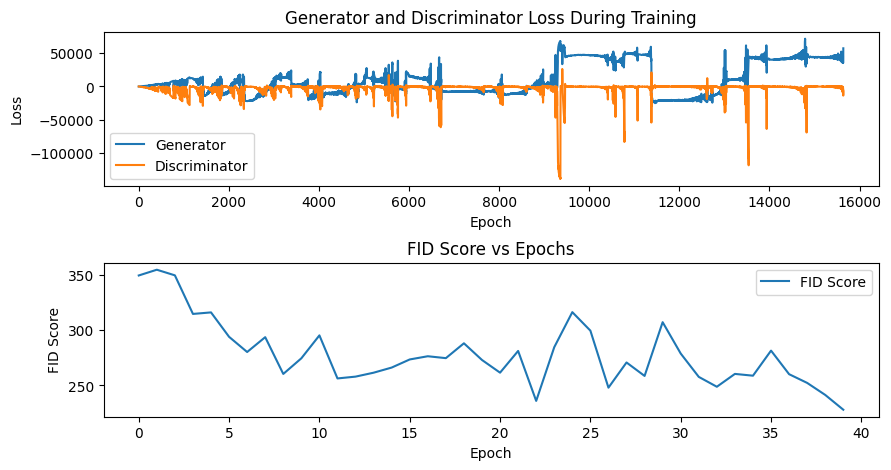

In [9]:
#Plotting Graphs

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(gen_losses, label="Generator")
plt.plot(dis_losses, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss During Training")

plt.subplot(2, 1, 2)
plt.plot(range(40), fid_scores, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.title("FID Score vs Epochs")

plt.subplots_adjust(hspace=0.5)

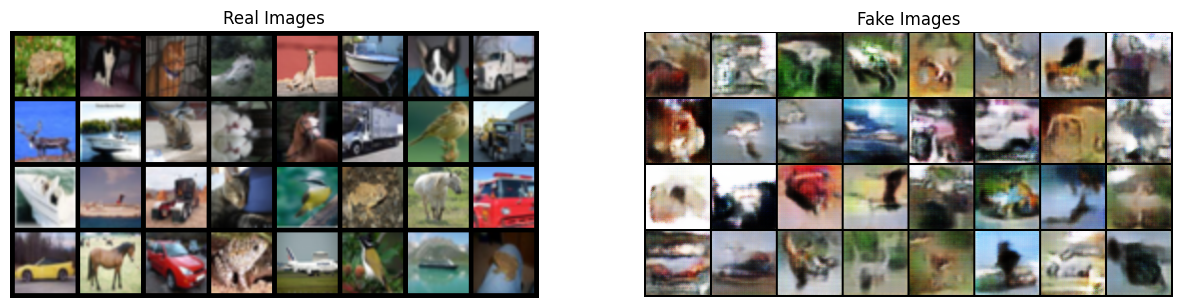

In [10]:
r_batch = next(iter(cifr_loader))

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(r_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(saved_images[-1],(1,2,0)))

plt.savefig('output_WGAN/WGAN_32_FAKE_IMAGES.png', format='png', bbox_inches='tight')
plt.show()